# Deep Dream Image Gen with CNN #

In [1]:
########### Basic Data Handling Import Set ###########
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Other:
import random

In [ ]:
########### Tensorflow Import ###########

# ON CONDA: pip install tensorflow==2.0.0-alpha0 # If any problem -> pip uninstall numpy -> pip install numpy
import tensorflow as tf
from tensorflow.keras import layers, models

## Model Load ##

In [4]:
base_model = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')
base_model.summary()

87916544/87910968 [==============================] - 21s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization_v1[0][0]     
_____________________

## Nota:
- O objetivo do algoritmo é selecionar uma camada para maximizar a loss function, que são as ativações
- Podemos selecionar qualquer camada, lembrando que as primeiras camadas possuem características mais simples (bordas) e camadas superiores possuem características mais complexas e detalhadas dos objetos
- A rede Inception possui múltiplas camadas concatenadas chamadas de 'mixed' 

In [6]:
# names = ['mixed8', 'mixed9']
#names = ['mixed3', 'mixed5', 'mixed8', 'mixed9']
names = ['mixed3', 'mixed5']
# names = ['mixed5']

layers = [base_model.get_layer(name).output for name in names]
layers

[<tf.Tensor 'mixed3/concat:0' shape=(None, None, None, 768) dtype=float32>,
 <tf.Tensor 'mixed5/concat:0' shape=(None, None, None, 768) dtype=float32>]

In [8]:
deepdream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

## Image Processing ##

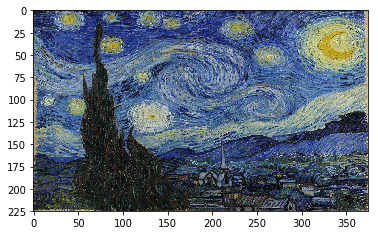

In [15]:
sample_image = tf.keras.preprocessing.image.load_img(r'StaryNight.jpg', target_size = (225, 375))
plt.imshow(sample_image);

## Pre-trained Model Execution and Activation Exploration ##

In [17]:
sample_image = tf.Variable(tf.keras.applications.inception_v3.preprocess_input(sample_image))
print(type(sample_image))

sample_image = tf.expand_dims(sample_image, axis = 0)
np.shape(sample_image)
print(sample_image.shape)

(225, 375, 3)
<class 'numpy.ndarray'>
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
(1, 225, 375, 3)


In [18]:
activations = deepdream_model(sample_image)
activations[1]

<tf.Tensor: id=11581, shape=(1, 12, 21, 768), dtype=float32, numpy=
array([[[[3.362313  , 4.1906238 , 3.9559407 , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 3.2915704 , ..., 0.        ,
          0.        , 0.        ],
         [1.1932619 , 2.8544993 , 0.96761096, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.04281157, 1.3122408 , 1.0145407 , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 2.0416849 , ..., 0.        ,
          0.        , 0.04361534],
         [1.5414131 , 1.8796788 , 1.8178947 , ..., 0.        ,
          0.        , 0.19873238]],

        [[1.193501  , 2.1502714 , 2.3389895 , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 4.6458354 , ..., 0.        ,
          0.        , 0.        ],
         [0.21733624, 1.6891674 , 0.23644605, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        

## Loss Calculation ##

- Calcularemos a loss que representa o somatório das ativações de uma camada específica
- Na maioria das vezes o objetivo é minizar o erro (loss) usando a descida gradiente, porém, em deep dream o objetivo é maximizar a loss 
- Isso é feito usando subida do gradiente (gradient ascent)
- A função encaminha a imagem pela rede neural e gera as ativações. Depois obtemos a soma das saídas

In [19]:
def calc_loss(image, model, test = 1):
    if test == 1:
        img_batch = tf.expand_dims(image, axis = 0)
        layer_activations = model(img_batch)
    else:
        layer_activations = model(image)

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    print('Losses from multiple activation layers = ', losses)
    print('Losses shape = ', np.shape(losses))
    print('Sum of all losses = ', tf.reduce_sum(losses))

    return tf.reduce_sum(losses)

In [21]:
loss = calc_loss(sample_image, deepdream_model, test = 0)
loss

Losses from multiple activation layers =  [<tf.Tensor: id=12849, shape=(), dtype=float32, numpy=0.2634555>, <tf.Tensor: id=12851, shape=(), dtype=float32, numpy=0.17727219>]
Losses shape =  (2,)
Sum of all losses =  tf.Tensor(0.4407277, shape=(), dtype=float32)


<tf.Tensor: id=12872, shape=(), dtype=float32, numpy=0.4407277>

## Gradient Ascendent ##

- Vamos utilizar a loss calculada no passo anterior e calcular o gradiente com respeito a imagem de entrada. Depois adicionamos os valores na imagem de entrada

In [22]:
@tf.function
def deepdream(model, image, step_size):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = calc_loss(image, model)

    gradients = tape.gradient(loss, image)
    gradients /= tf.math.reduce_std(gradients)
    image = image + gradients * step_size
    image = tf.clip_by_value(image, -1, 1)

    return loss, image

In [23]:
def run_deep_dream_simple(model, image, steps = 100, step_size = 0.01):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    for step in range(steps):
        loss, image = deepdream(model, image, step_size)

    if step % 100 == 0:
        plt.figure(figsize=(12,12))
        plt.imshow(deprocess(image))
        plt.show()
        print('Step {}, loss {}'.format(step, loss))
  
    plt.figure(figsize=(12,12))
    plt.imshow(deprocess(image))
    plt.show()

    return deprocess(image)

In [24]:
def deprocess(image):
    image = 255 * (image + 1.0) / 2.0
    return tf.cast(image, tf.uint8)

## First Test ##

In [ ]:
test_image = tf.keras.preprocessing.image.load_img(r'StaryNight.jpg', target_size = (225, 375))
test_image = np.array(test_image)
test_image = tf.keras.applications.inception_v3.preprocess_input(test_image)
np.shape(test_image)

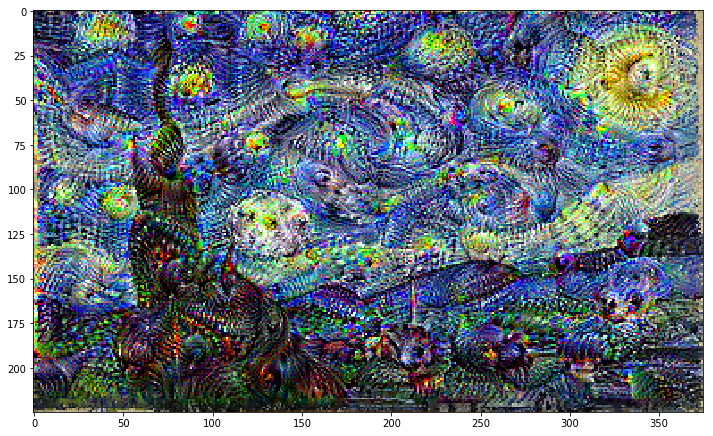

In [27]:
dream_img = run_deep_dream_simple(model = deepdream_model, image = test_image, steps = 2000, step_size = 0.001)

## More Dimensions Testing ##

In [34]:
scale = 1.3
test_image2 = tf.keras.preprocessing.image.load_img(r'sky.jpeg', target_size = (225, 375))

image = tf.constant(np.array(test_image2))
base_shape = tf.cast(tf.shape(image)[:-1], tf.float32)

In [35]:
type(image)

tensorflow.python.framework.ops.EagerTensor

In [36]:
np.shape(image)

TensorShape([225, 375, 3])

In [37]:
type(base_shape)

tensorflow.python.framework.ops.EagerTensor

In [38]:
np.shape(base_shape)

TensorShape([2])

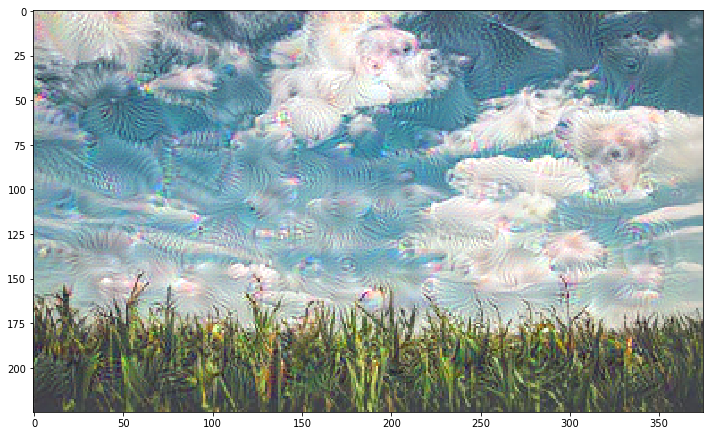

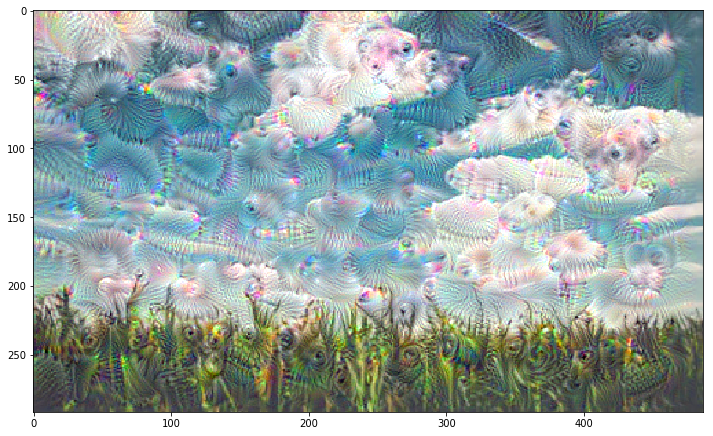

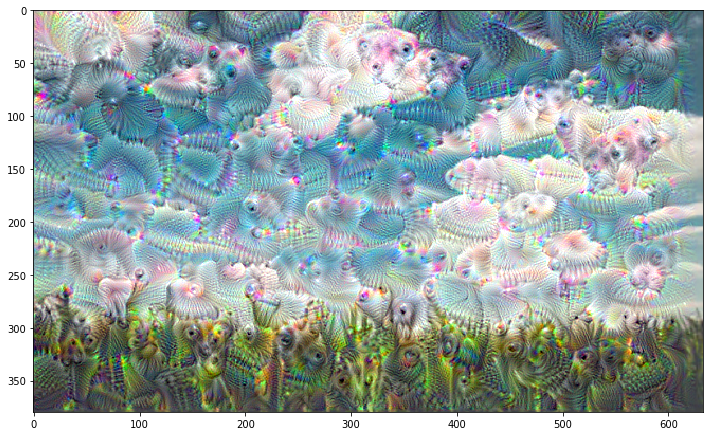

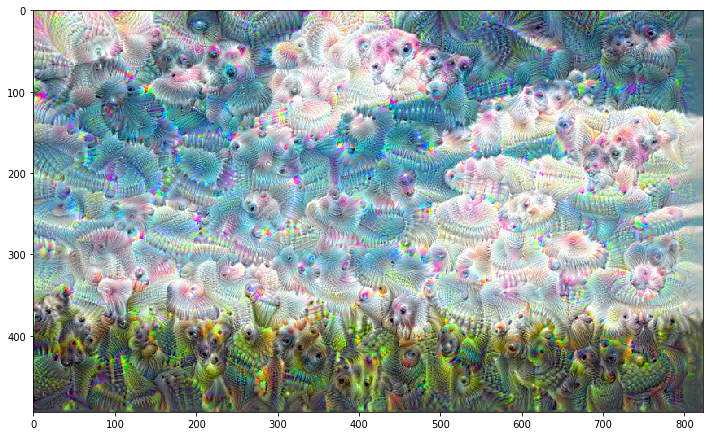

KeyboardInterrupt: 

In [39]:
for n in range(5):
    new_shape = tf.cast(base_shape * (scale**n), tf.int32)
    image = tf.image.resize(image, new_shape).numpy()
    image = run_deep_dream_simple(model=deepdream_model,image = image, steps = 400, step_size = 0.001)